In [92]:
! pip install librosa

Python(22697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [89]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [93]:
import numpy as np
import pandas as pd

import librosa
from scipy.io import wavfile

In [94]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, AdamW, get_linear_schedule_with_warmup

In [95]:
# 데이터 로드
df_all_txt = pd.read_csv("df_calculation.csv")

In [96]:
all_wav_tmp = df_all_txt["wav_id"].tolist()
all_emotion = df_all_txt["label"].tolist()

In [97]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import torch

# Wav2Vec2 Processor 및 모델 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=4)

# 모델을 MPS로 이동 (MPS가 지원되지 않으면 CPU로 설정)
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
device = torch.device("cpu")

model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [98]:
# audio data -> wav2vec input
def audio2input(filepath):
    samplerate, audio = wavfile.read(filepath, mmap=True)
    if samplerate != 16000:  # Check if the sampling rate is different from 16000 Hz
        audio = librosa.resample(audio.astype(np.float32), orig_sr=samplerate, target_sr=16000)  # Resample to 16000 Hz if necessary
    input_values = processor(audio, sampling_rate=16000, return_tensors="pt").input_values  # Explicitly set sampling rate
    return input_values

In [91]:
import torch

# 장치 설정: MPS가 가능하면 MPS를 사용하고, 그렇지 않으면 CPU를 사용
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

device = torch.device("cpu")

docs = []
total_files = len(all_wav_tmp)


for i in range(total_files):
    filename = all_wav_tmp[i]
    label = all_emotion[i]

    input_values = audio2input(f"merged_wav_folder/{filename}.wav")
    input_values = input_values.to(device)  # 입력 데이터를 MPS 또는 CPU로 이동

    docs.append({
        'fileName': filename,
        'input_values': input_values,
        'label': torch.tensor([int(label)], device=device)  # 레이블을 정수로 변환 후 MPS 또는 CPU로 이동
    })

    # 진행 상황 출력 (100개마다)
    if (i + 1) % 100 == 0 or (i + 1) == total_files:
        print(f"Processed {i+1}/{total_files} files...")

Processed 100/15463 files...
Processed 200/15463 files...
Processed 300/15463 files...
Processed 400/15463 files...
Processed 500/15463 files...
Processed 600/15463 files...
Processed 700/15463 files...
Processed 800/15463 files...
Processed 900/15463 files...
Processed 1000/15463 files...
Processed 1100/15463 files...
Processed 1200/15463 files...
Processed 1300/15463 files...
Processed 1400/15463 files...
Processed 1500/15463 files...
Processed 1600/15463 files...
Processed 1700/15463 files...
Processed 1800/15463 files...
Processed 1900/15463 files...
Processed 2000/15463 files...
Processed 2100/15463 files...
Processed 2200/15463 files...
Processed 2300/15463 files...
Processed 2400/15463 files...
Processed 2500/15463 files...
Processed 2600/15463 files...
Processed 2700/15463 files...
Processed 2800/15463 files...
Processed 2900/15463 files...
Processed 3000/15463 files...
Processed 3100/15463 files...
Processed 3200/15463 files...
Processed 3300/15463 files...
Processed 3400/1546

In [99]:
# # # output_file.txt에서 파일명을 읽어와서 리스트로 저장 (output_file.txt)
# # with open('/content/drive/MyDrive/Text_Audio_Multimodal/output_file.txt', 'r') as f:
# #     wav_files_to_load = [line.strip().replace('.wav', '') for line in f.readlines()]

# # output_file.txt에서 파일명을 읽어와서 리스트로 저장 (filtered_output_file.txt -> )
# with open('/content/drive/MyDrive/Text_Audio_Multimodal/filtered_output_file.txt', 'r') as f:
#     wav_files_to_load = [line.strip() for line in f.readlines()]

# print(wav_files_to_load)

In [100]:
# import time

# docs = []
# total_files = len(wav_files_to_load)

# start_time = time.time()

# for i in range(total_files):
#     filename = all_wav_tmp[i]
#     label = all_emotion[i]

#     # output_file.txt에 있는 파일만 처리
#     if filename in wav_files_to_load:
#         input_values = audio2input(f"/content/drive/MyDrive/Text_Audio_Multimodal/data/merged_wav_folder/{filename}.wav")
#         input_values = input_values.to('cuda')

#         docs.append({
#             'fileName': filename,
#             'input_values': input_values,
#             'label': torch.tensor([int(label)], device='cuda')  # Convert label to integer
#         })

#         # 진행 상황 출력
#         if (i + 1) % 100 == 0 or (i + 1) == total_files:
#             print(f"Processed {i+1}/{total_files} files...")

# # 최종적으로 걸린 시간 출력
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"All selected files have been processed in {elapsed_time:.2f} seconds.")


In [101]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cpu")
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [102]:
# Dataset 정의
class AudioDataset(Dataset):
    def __init__(self, docs):
        self.docs = docs
    
    def __len__(self):
        return len(self.docs)
    
    def __getitem__(self, idx):
        item = self.docs[idx]
        return {
            'input_values': item['input_values'],
            'label': item['label']
        }

In [103]:
# Collate 함수 정의 (batch 내 tensor 크기 맞추기)
def collate_fn(batch):
    # 모든 input_values를 리스트로 모음
    input_values = [item['input_values'].squeeze(0) for item in batch]
    
    # 가장 긴 텐서 길이에 맞춰 나머지를 패딩 (기본적으로 0으로 패딩)
    padded_input_values = rnn_utils.pad_sequence(input_values, batch_first=True, padding_value=0)
    
    # 레이블도 동일한 방식으로 모음
    labels = torch.cat([item['label'] for item in batch], dim=0)
    
    return {'input_values': padded_input_values, 'labels': labels}


In [104]:
# 데이터셋 생성
dataset = AudioDataset(docs)

# DataLoader 정의 (배치 사이즈는 16으로 예시)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Optimizer 및 Loss 함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

In [105]:
# 학습 루프
num_epochs = 10  # 학습할 epoch 수
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()  # 옵티마이저 초기화

        # 모델에 입력값을 넣고 출력 계산
        outputs = model(input_values).logits
        
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화 단계
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 에포크마다 평균 손실 출력
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

Epoch 1/10:   2%|▏         | 15/967 [09:30<10:59:32, 41.57s/it]

In [ ]:
# 학습 완료 후 모델 저장
torch.save(model.state_dict(), "wav2vec2_finetuned_model.pt")

In [37]:
# Train / Test Split
# data split(total 15463) -> 12370(0.8)+3093(0.2)
train_list = docs[:12370]
test_list = docs[12370:]

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-4, eps=1e-8)

total_steps = len(train_list) * NUM_EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

total_steps = 1

In [73]:
import torch
from torch.utils.data import DataLoader, Dataset

# collate_fn 함수 정의
def collate_fn(batch):
    # 배치에서 입력과 라벨 추출
    input_values, labels = zip(*batch)

    # 텍스트 데이터를 숫자로 변환하는 과정이 필요합니다.
    # 여기에서는 input_values가 이미 텐서로 변환된 상태라고 가정합니다.
    
    # 입력값의 길이 측정
    lengths = [x.size(0) for x in input_values]
    max_length = max(lengths)

    # 패딩을 추가하여 입력값의 길이를 맞춤 (MPS로 옮김)
    padded_input_values = torch.stack([
        torch.cat([x.to(device), torch.zeros(max_length - x.size(0), dtype=x.dtype).to(device)]) 
        for x in input_values
    ])

    # 라벨을 텐서로 변환 (MPS로 옮김)
    labels = torch.tensor(labels).to(device)

    return padded_input_values, labels

# 배치 사이즈 설정
BATCH_SIZE = 32

# 데이터셋 생성
train_dataset = CustomDataset(train_list)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# 손실 및 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []
total_steps = 0

# 학습
for epoch in range(NUM_EPOCHS):
    model.train()

    # 에포크 시작 시간 기록
    start_time = time.time()

    epoch_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in train_dataloader:
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)  # GPU로 전송

        optimizer.zero_grad()
        outputs = model(input_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        # 예측 및 라벨 저장
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_steps += 1

    # 에포크 종료 시간 기록 및 경과 시간 계산
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 경과 시간을 시/분/초로 변환하여 출력
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f'Epoch {epoch + 1} completed in {int(hours)}h {int(minutes)}m {int(seconds)}s')

    # 에포크별 평균 손실 계산
    avg_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # 에포크별 정확도 계산
    accuracy = accuracy_score(all_labels, all_preds)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1} Training Loss: {avg_loss:.4f} Training Accuracy: {accuracy:.4f}')


AttributeError: 'str' object has no attribute 'size'

In [71]:
# 모델 학습 루프
import time
from sklearn.metrics import accuracy_score

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# 손실 및 정확도를 저장할 리스트 초기화
train_losses = []
train_accuracies = []

# 학습
for epoch in range(NUM_EPOCHS):
    model.train()
    model.to(device)  # 모델을 MPS 디바이스로 이동

    # 에포크 시작 시간 기록
    start_time = time.time()

    epoch_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        input_values = batch['input_values'].to(device)  # MPS 디바이스로 전송
        labels = batch['label'].to(device)  # MPS 디바이스로 전송

        optimizer.zero_grad()
        outputs = model(input_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        # 예측 및 라벨 저장
        preds = torch.argmax(outputs.logits, dim=-1)  # 예측 결과의 차원을 확인합니다.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # 에포크 종료 시간 기록 및 경과 시간 계산
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 경과 시간을 시/분/초로 변환하여 출력
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f'Epoch {epoch + 1} completed in {int(hours)}h {int(minutes)}m {int(seconds)}s')

    # 에포크별 평균 손실 계산
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 에포크별 정확도 계산
    accuracy = accuracy_score(all_labels, all_preds)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1} Training Loss: {avg_loss:.4f} Training Accuracy: {accuracy:.4f}')

AttributeError: 'str' object has no attribute 'to'

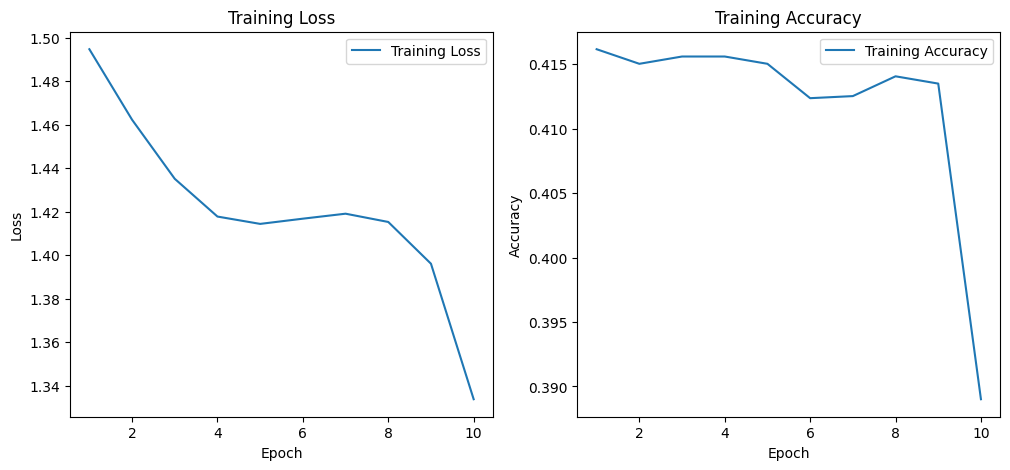

In [20]:
# 손실 및 정확도 그래프 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [ ]:
# 학습 모델 저장
torch.save(model, './audio_train_model.pt')